# Symmetry Detection
NoteBook for detecting symmetry for problem statement 2 of Adobe GenSolve Hackathon:
Detecting vertical, horizontal and radial symmetry in input shapes

In [1]:
pip install opencv-python numpy pandas scikit-learn matplotlib

Import the required libraries

In [2]:
import numpy as np
import os
import cv2
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from cv2 import polylines
from sklearn.cluster import DBSCAN

**DB Scan clustering**

DBSCAN Clustering

Shapes are extracted from the combined set of polylines using DBSCAN clustering. This allows to distinguish collection of shapes that are together e.g. a line inside a circle from the ones that are far apart e.g. a rectanle and a star with some distance in between.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that identifies clusters based on the density of data points. It works by marking points as core points if they have a minimum number of neighboring points within a specified radius (ε). Clusters are formed by connecting core points and their neighbors, while points that do not meet the density criteria are considered noise. DBSCAN can discover clusters of arbitrary shape, does not require specifying the number of clusters beforehand, and is effective at handling noise and outliers in the data.

After the points are clustered, the paths containing those points are extracted from the polylines. Every cluster can be considered as a single shape.

Overlaps are detected inside a cluster by checking if within a cluster, a point of a particular path is very close (lesser than a threshold) to another point in a different path or subpath within the same cluster.

The path with the maximum overlapping points is the occluded path that is to be completed, because it has overlapping points with all the different paths occlude it. The occluded path is extracted for completion

In [3]:
def read_csv(csv_path):
    """
    Read CSV for the given points (provided from GenSolve)
    """
    data = np.genfromtxt(csv_path, delimiter=',')
    paths = {}
    for row in data:
        path_id, sub_path_id, x, y = row
        if path_id not in paths:
            paths[path_id] = {}
        if sub_path_id not in paths[path_id]:
            paths[path_id][sub_path_id] = []
        paths[path_id][sub_path_id].append((x, y))
    return paths

def dict_to_numpyarray(polylines):
    """
    convert the polyline dictionary into a numpy array containg all the paths and subpaths
    """
    path_XYs = []  # init empty list to store the formatted paths
    # iterate over each path_id in the dictionary, sorted by the path_id
    for path_id in sorted(polylines.keys()):
        sub_paths = []  # init empty list to store the sub-paths for the current path_id
        # iterate over each sub_path id in the current path_id, sorted by the sub_path_id
        for sub_path_id in sorted(polylines[path_id].keys()):
            # convert the list of (x,y) tuples into a NumPy array
            XY = np.array(polylines[path_id][sub_path_id])
            # check if the array has atleast two columns (x and y)
            if XY.shape[1] >= 2:
                # if valid, append the numpy array to the sub_paths list
                sub_paths.append(XY)
            else:
                print(f"Skipped malformed data: {XY}")
        path_XYs.append(sub_paths)
    return path_XYs

def extract_clusters(polylineNDArray):
    """
    Extract point clusters (shapes) from the polylines using DBscan
    """
    # Step 3: Apply DBSCAN clustering
    db = DBSCAN(eps=7, min_samples=10).fit(polylineNDArray)  # create DBSCAN clustering object and fit to X
    core_samples_mask = np.zeros_like(db.labels_,
                                      dtype=bool)  # create a boolean mask with the same size as the labels array filled with zeros to identify core samples later
    core_samples_mask[
        db.core_sample_indices_] = True  # sets the elements of the core_samples_mask corresponding to core samples
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    clustered_data = []

    # Step 4: Visualization
    unique_labels = set(labels)
    # firstly assign a plotcolor value to each unique label as a dictionary
    # for k, col in zip(unique_labels, plotcolors):
    for k in unique_labels:
        # creates a mask that selects points beloging to the current cluster k
        class_member_mask = (labels == k)

        # core_samples_mask is a boolean array indicating the points which beling to the current cluster k
        # performs element-wise logical AND between the two masks, meaning only the points belonging to both
        # the current cluster and the core samples are selected
        # resulting data points are assigned to xy
        xy = polylineNDArray[class_member_mask & core_samples_mask]
        clustered_data.append([k, xy])

    print(f"Number of clusters detected: {n_clusters_}")
    return clustered_data

def clusters_from_polylines(polyline_np_array, clusters):
    """
    Extract the clusters from the given polylines.
    Args:
        polyline_np_array (numpy array of polylines) and clusters (list of detected clusters)
    Returns:
        extracted_clusters = [[[(x1, y1), (x2, y2)]]]
    """
    # first create a list for the clusters to be extracted
    extracted_clusters = []
    for _, cluster_data in enumerate(clusters):
        cluster_id, cluster_points = cluster_data
        # skip including for the noise cluster
        if cluster_id == -1:
            continue
        extracted_clusters.append([])
        # we put the entire path into the cluster in this case
        for path_index, path in enumerate(polyline_np_array):
            path_added = False  # flag to indicate if the path was added as an extracted cluster
            # if a point in the path exists in the cluster, put the entire path into the cluster
            # and move on to the next path
            for subpath_idex, subpath in enumerate(path):
                for point_index, point in enumerate(subpath):
                    if np.any(np.all(point == cluster_points, axis=1)):
                        extracted_clusters[cluster_id].append(path)
                        path_added = True
                        break
                if path_added:
                    break
    return extracted_clusters

def dict_to_numpy_combined(polylines):
    """
    Only for clustering. Convert all the points into a single numpy array for clustering using DBscan
    Returns: [(x1, y1),(x2, y2)]
    """
    path_XYs = []
    for path_id in sorted(polylines.keys()):
        sub_paths = []
        for sub_path_id in sorted(polylines[path_id].keys()):
            XY = np.array(polylines[path_id][sub_path_id])
            if XY.shape[1] >= 2:
                sub_paths.append(XY)
            else:
                print(f"Skipped malformed data: {XY}")
        path_XYs.extend(sub_paths)  # Flatten into a single list of arrays
    return np.vstack(path_XYs)  # Combine all arrays into one


Plot Colors

In [4]:
plotcolors = [
    "#FF0000",  # Red
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#800080",  # Purple
    "#FF7F00",  # Orange
    "#FFC0CB",  # Pink
    "#A52A2A",  # Brown
    "#808080",  # Gray
    "#008080",  # Teal
    "#E6E6FA",  # Lavender
    "#808000",  # Olive
    "#800000",  # Maroon
    "#000080",  # Navy
    "#40E0D0",  # Turquoise
    "#FF7F50",  # Coral
    "#00FF7F",  # Spring Green
    "#FFD700",  # Gold
    "#C0C0C0",  # Silver
    "#FF00FF",  # Magenta
    "#8B0000",  # Dark Red
    "#2E8B57",  # Sea Green
    "#DAA520",  # Goldenrod
    "#4B0082",  # Indigo
    "#00CED1",  # Dark Turquoise
    "#9400D3",  # Dark Violet
    "#FF1493",  # Deep Pink
    "#708090",  # Slate Gray
    "#8B4513",  # Saddle Brown
    "#556B2F",  # Dark Olive Green
    "#6A5ACD",  # Slate Blue
    "#4682B4",  # Steel Blue
    "#FF6347",  # Tomato
    "#7FFF00",  # Chartreuse
    "#D2691E"  # Chocolate
]

def image_from_numpyarray(path_XYs):
    """
    Create a single channel edge image for the given formatted polyline numpy array.
    """
    max_x, max_y = 0, 0
    # Ensure only valid arrays are processed
    for XYs in path_XYs:
        for XY in XYs:
            if XY.shape[1] >= 2:  # Check if XY has at least two columns (x and y)
                max_x = max(max_x, int(np.max(XY[:, 0])))
                max_y = max(max_y, int(np.max(XY[:, 1])))

    # Create a blank image
    image = np.zeros((max_y + 10, max_x + 10, 3), dtype=np.uint8)

    # Draw the shapes on the image
    for XYs in path_XYs:
        for XY in XYs:
            if XY.shape[1] >= 2:  # Ensure valid XY arrays are processed
                points = np.array([(x, y) for x, y in XY], np.int32)
                points = points.reshape((-1, 1, 2))
                cv2.polylines(image, [points], isClosed=False, color=(255, 255, 255), thickness=2)

    return image

**Vertical and Horizontal Symmetry Detection**

First, the image is converted to grayscale and then thresholded to create a binary image, highlighting the shapes of interest. The largest contour in the binary image, which represents the primary shape, is identified. The image is then split into two halves: left and right halves for vertical symmetry, and top and bottom halves for horizontal symmetry.

To check for vertical symmetry, the right half of the shape is flipped horizontally and compared to the left half using the compare_halves function. This function calculates the absolute difference between corresponding pixels in the two halves. If the number of differing pixels is within a specified threshold (allowing for minor variations), the shape is considered vertically symmetric.

Similarly, for horizontal symmetry, the top half is compared to a vertically flipped bottom half. If the difference ratio between the two halves is within the acceptable threshold, the shape is considered horizontally symmetric.

If either type of symmetry is detected, a corresponding line of symmetry is drawn on the image. This method allows for small imperfections in symmetry while still identifying the overall symmetric structure of the shape.

In [5]:
def compare_halves(half1, half2, threshold=0.05):
    """Compare two halves of an image, allowing for small differences."""
    # Ensure both halves are the same size
    if half1.shape != half2.shape:
        h, w = half1.shape[:2]
        half2 = cv2.resize(half2, (w, h))

    # Calculate the absolute difference between the two halves
    diff = cv2.absdiff(half1, half2)

    # Count the number of non-zero (different) pixels
    non_zero_count = np.count_nonzero(diff)

    # Calculate the percentage of different pixels
    total_pixels = half1.size
    difference_ratio = non_zero_count / total_pixels

    # Check if the difference is within the acceptable threshold
    return difference_ratio < threshold


def detect_and_draw_symmetry(image, threshold=0.05):
    # Load the image and convert to grayscale

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours of the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour is the shape of interest
    contour = max(contours, key=cv2.contourArea)

    # Get bounding rectangle for the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Check vertical symmetry by comparing left and right halves
    left_half = binary[y:y + h, x:x + w // 2]
    right_half = cv2.flip(binary[y:y + h, x + w // 2:x + w], 1)

    # Ensure right_half is resized to match left_half if necessary
    if w % 2 != 0:
        right_half = right_half[:, :-1]  # Trim last column if width is odd

    if compare_halves(left_half, right_half, threshold):
        print("The shape has vertical symmetry.")
        # Draw the vertical line of symmetry
        cv2.line(image, (x + w // 2, y), (x + w // 2, y + h), (0, 255, 0), 2)
    else:
        print("The shape does not have vertical symmetry.")

    # Check horizontal symmetry by comparing top and bottom halves
    top_half = binary[y:y + h // 2, x:x + w]
    bottom_half = cv2.flip(binary[y + h // 2:y + h, x:x + w], 0)

    # Ensure bottom_half is resized to match top_half if necessary
    if h % 2 != 0:
        bottom_half = bottom_half[:-1, :]  # Trim last row if height is odd

    if compare_halves(top_half, bottom_half, threshold):
        print("The shape has horizontal symmetry.")
        # Draw the horizontal line of symmetry
        cv2.line(image, (x, y + h // 2), (x + w, y + h // 2), (0, 255, 0), 2)
    else:
        print("The shape does not have horizontal symmetry.")

    # Display the result
    # cv2.imshow('Symmetry Detection', image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Symmetry Detection")
    plt.axis('off')  # Hide the axis
    plt.show()

**Star Detection**
First, the input image is converted to grayscale and thresholded to create a binary image where contours can be detected. The contours of the binary image are then found using OpenCV's findContours function. Each detected contour is analyzed to determine if it resembles a star shape by checking if it has a sufficient number of vertices (typically 10 or more). To further validate the star shape, the contour is fitted with a regular star shape by calculating its center and radius, then generating a star with specified points and size. If a contour matches these criteria, it is classified as a star, and the contour is drawn on the image for visualization.

In [6]:
def is_star(contour):
    # Calculate the perimeter of the contour
    perimeter = cv2.arcLength(contour, True)
    # Approximate the shape
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)

    # Check if the contour has 10 or more points (stars typically have many points)
    if len(approx) >= 10:
        return True
    return False


def detect_star(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply binary thresholding
    _, threshold = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)

    # Find contours in the threshold image
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if is_star(contour):
            # Draw the contour
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
            print("Star shape detected!")

    # Display the result
    # cv2.imshow("Star Detection", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


**Circle Detection**
Circles are identified within a set of polylines using the Hough Circle Transform. First, it converts the polylines into an image and then to grayscale. The grayscale image is blurred to reduce noise, making circle detection more accurate. The Hough Circle Transform is then applied, which works by identifying circular shapes based on the gradient information in the image. It returns the parameters (center coordinates and radius) of detected circles.

In [7]:
def detect_circles(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be read.")
    img = cv2.medianBlur(img, 5)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 30, param1=100, param2=30, minRadius=60, maxRadius=500)
    return circles


def draw_circle(image_path, circle_info):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be read.")

    # Extract circle information
    x, y, r = circle_info[0][0]  # Circle info: [x, y, r]

    # Draw the circle in green
    cv2.circle(img, (int(x), int(y)), int(r), (0, 255, 0), 4)
    # Draw the center of the circle in red
    cv2.circle(img, (int(x), int(y)), 2, (0, 0, 255), 3)

    # Display the result
    # cv2.imshow("Circle Detected", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def save_circles_to_csv(circles, csv_path):
    if circles is not None:
        circles = np.uint16(np.around(circles))
        with open(csv_path, 'w', newline='') as file:
            writer = csv.writer(file)
            for circle in circles[0, :]:
                writer.writerow(circle)
        print(f'Circle data saved to: {csv_path}')
    else:
        print("No circles to save.")

def draw_circles_on_image(image, circles, output_image_path):
    """
    Draw circles on the image and save it to the specified path.
    Args:
        image: The image to draw circles on.
        circles: The circles detected by HoughCircles.
        output_image_path: The path where the output image will be saved.
    """
    if circles is not None:
        for circle in circles[0, :]:
            # Extract the center coordinates and radius
            center_x, center_y, radius = int(circle[0]), int(circle[1]), int(circle[2])
            # Draw the circle on the image
            cv2.circle(image, (center_x, center_y), radius, (0, 255, 0), 2)  # Use cv.circle for drawing

    # Save the modified image
    # cv2.imwrite(output_image_path, image)


**Rectangle Detection**
First, the image is converted to grayscale, blurred to reduce noise, and then thresholded to create a binary image. Contours are extracted from this binary image to identify potential shapes. Each contour is approximated to a polygon, and rectangles are specifically identified by checking if the polygon has four vertices. To ensure the detected shape is a rectangle, its aspect ratio is checked to be within a predefined range. If these criteria are met, the rectangle's coordinates are stored. Finally, the detected rectangles are converted into polylines, where each rectangle is represented as a series of connected lines, and this representation is returned for further processing or visualization.

In [8]:
import cv2
import numpy as np


def detect_rectangles(image_path):
    # Read the image
    im = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if im is None:
        raise FileNotFoundError("Image not found!")

    # Convert the image to grayscale
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(imgray, (5, 5), 0)

    # Threshold the grayscale image
    _, thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Define the aspect ratio thresholds for detecting rectangles
    aspect_ratio_min = 0.8
    aspect_ratio_max = 1.2

    # To store detected rectangles
    detected_rectangles = []

    # Iterate through the contours
    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the polygon has 4 vertices
        if len(approx) == 4:
            # Get bounding box to calculate aspect ratio
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h

            # Check if the aspect ratio is within the defined range
            if aspect_ratio_min < aspect_ratio < aspect_ratio_max:
                # Draw the detected rectangle on the image
                cv2.drawContours(im, [approx], -1, (0, 255, 0), 2)

                # Store the rectangle coordinates
                rect_points = approx.reshape(-1, 2)
                detected_rectangles.append(rect_points)

    return detected_rectangles


Load the csv file

In [20]:
csv_file = read_csv('/content/isolated_sol.csv')

Main Function

In [17]:
points_numpy_combined = dict_to_numpy_combined(csv_file)

# Extract clusters from the points
clusters = extract_clusters(points_numpy_combined)
print("Clusters detected:", len(clusters))

# Convert dictionary to numpy array for polylines
polylines_numpy = dict_to_numpyarray(csv_file)
clustered_polylines = clusters_from_polylines(polylines_numpy, clusters)

Number of clusters detected: 1
Clusters detected: 2


Looping through the clusters

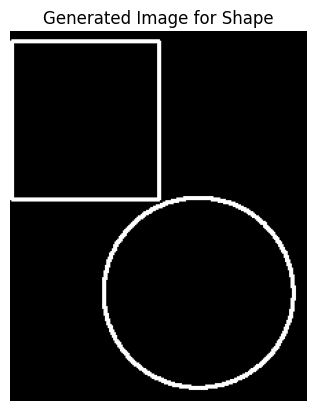

The shape has vertical symmetry.
The shape has horizontal symmetry.


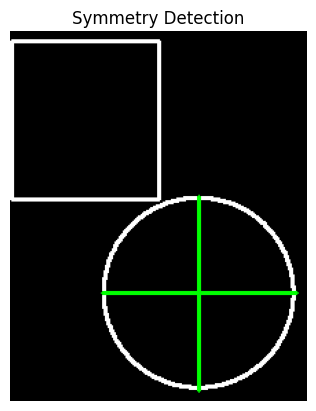

Radial Symmetry detected for circle.
Radial Symmetry detected for rectangle.


In [21]:
# Process each cluster
for _, shape in enumerate(clustered_polylines):
    if shape:
        image = image_from_numpyarray(shape)
        image_path = f"shape.png"
        cv2.imwrite(image_path, image)
        # cv2.imshow(f"Generated Image for Shape ", image)
        # Display the image using Matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Generated Image for Shape")
        plt.axis('off')  # Hide the axis
        plt.show()
        detect_and_draw_symmetry(image)

        # Circle Detection
        circles = detect_circles(image_path)
        if circles is not None:
            print("Radial Symmetry detected for circle.")

        # Rectangle detection
        if os.path.exists(image_path):
            detected_rectangles = detect_rectangles(image_path)
            if detected_rectangles:
                print("Radial Symmetry detected for rectangle.")

        # Star detection
        stars = detect_star(image_path)
        if stars is not None:
            print("Radial Symmetry detected for star.")
            print("Star Shape Detected")